# Import packages and connect to Bigquery

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/private-key.json"

In [3]:
!pip install pandasql

from pandasql import sqldf
sql_run = lambda x: sqldf(x, globals())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=193ed3cfda2bebd5b7eefbf1fa3320fb5e8e4d600968c2908e3377c9baa4e5ff
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


# A.	Data Description

### Query String

In [760]:
bqclient = bigquery.Client()

query_string = """
SELECT
  *
FROM 
  `bitlabs-dab.G_CID_01.neverforget_transactions_Q1_2018`
UNION ALL
SELECT
  *
FROM
  `bitlabs-dab.G_CID_01.neverforget_transactions_Q1_2019`
UNION ALL
SELECT
  *
FROM
  `bitlabs-dab.G_CID_01.neverforget_transactions_Q1_2020`
"""

df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)

### Add a new column

In [766]:
df['gmv'] = df['price'] * df['product_quantity']
df['revenue'] = (df['price']*df['product_quantity']) * df['percentage_commission']

In [767]:
print(df[['gmv', 'revenue']])

             gmv     revenue
0      5610000.0  11220000.0
1      5610000.0  11220000.0
2      6710000.0  13420000.0
3      6710000.0  13420000.0
4      6710000.0  13420000.0
...          ...         ...
56994   220000.0    660000.0
56995   220000.0    660000.0
56996   220000.0    660000.0
56997   319000.0    957000.0
56998   800000.0   2000000.0

[56999 rows x 2 columns]


In [768]:
def func(row):
  if row['payment_datetime'] is pd.NaT:
    return 'not paid'
  else:
    return 'paid'

In [769]:
df['is_paid'] = df.apply(func, axis=1)

In [770]:
df.is_paid.value_counts()

paid    56999
Name: is_paid, dtype: int64

In [771]:
def func(row):
  if row['payment_datetime'] is not pd.NaT and row['received_datetime'] is not pd.NaT:
    return 'non refund'
  else:
    return 'refund'

In [772]:
df['refund_status'] = df.apply(func, axis=1)

In [773]:
df.refund_status.value_counts()

non refund    53287
refund         3712
Name: refund_status, dtype: int64

### Column Description

In [761]:
df.columns

Index(['order_id', 'oder_detail_id', 'order_datetime', 'item_id', 'item_name',
       'cat_name', 'price', 'product_quantity', 'percentage_commission',
       'payment_method', 'payment_datetime', 'processed_datetime',
       'delivered_datetime', 'received_datetime', 'settled_datetime',
       'buyer_id', 'seller_id', 'order_source', 'buyer_province_name',
       'buyer_city_name', 'logistic_name'],
      dtype='object')

In [762]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56999 entries, 0 to 56998
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   order_id               56999 non-null  object             
 1   oder_detail_id         56999 non-null  object             
 2   order_datetime         56999 non-null  datetime64[ns, UTC]
 3   item_id                56999 non-null  object             
 4   item_name              56999 non-null  object             
 5   cat_name               56999 non-null  object             
 6   price                  56999 non-null  float64            
 7   product_quantity       56999 non-null  Int64              
 8   percentage_commission  56999 non-null  float64            
 9   payment_method         56999 non-null  object             
 10  payment_datetime       56999 non-null  datetime64[ns, UTC]
 11  processed_datetime     53325 non-null  datetime64[ns, 

In [764]:
df.describe()

,price,product_quantity,percentage_commission
count,5.699900e+04,56999.000000,56999.000000
mean,8.769933e+05,18.819032,2.206977
std,6.009249e+06,134.792396,1.389401
min,1.000000e+04,11.000000,0.000000
25%,3.500000e+04,11.000000,2.000000
50%,1.100000e+05,12.000000,2.000000
75%,2.810000e+05,14.000000,3.000000
max,2.997600e+08,10010.000000,10.000000


In [763]:
df_desc = pd.read_csv('/content/drive/MyDrive/Data_Desc.csv')
df_desc

,Column Name,Data Type (Description)
0,order_id,String (Order Identification Number)
1,order_detail_id,String (Order Detail Identification Number)
2,order_datetime,"Datetime (Q1 2018, 2019, 2020)"
3,item_id,String (Item/Product Identification Number)
4,item_name,String (Product Name)
5,cat_name,String (Category Name)
6,price,Float (Price in Rupiah)
7,product_quantity,Integer (Quantity of Products)
8,gmv,Float (Gross Merchandise Value of the Order = ...
9,percentage_commission,Float (Take Rate of GMV that Seller Give to Ra...


*   `order_id` merupakan data `string` berisi kode unik yang menjadi identitas unik saat customer melakukan transaksi di neverforget
*   `order_detail_id` merupakan detail dari data `string` berisi kode unik yang menjadi identitas unik saat customer melakukan transaksi di neverforget
*   `order_datetime` merupakan data `timestamp` yang dibuat saat customer melakukan transaksi
*   `item_id` merupakan data `string` yang menjadi Product Identification Number masing-masing produk yang dijual
*   `item_name` merupakan data `string` yang berisi nama masing-masing produk yang dijual
*   `cat_name` merupakan nama dari kategori items yang ada di neverforget
*   `price` merupakan harga dari suatu item
*   `product_quantity` merupakan kuantitas atau jumlah barang yang dibeli
*   `gmv` atau gross merchandise value merupakan nilai yang muncul dari perkalian `price` dengan `product_quantity`
*   `percentage_commision` adalah persentase pembagian hasil penjualan (komisi) di neverforget
*   `revenue` adalah nilai dari pendapatan dari komisi penjualan yang diterima oleh neverforget dari perkalian `gmv` * `percentage_commission`
*   `payment_method` adalah metode pembayaran yang digunakan oleh `buyer_id` saat melakukan transaksi di neverforget
*   `payment_datetime` adalah tanggal/`timestamp` saat `buyer_id` melakukan pembayaran saat transaksi di neverforget
*   `processed_datetime` adalah tanggal/`timestamp` saat pesanan `buyer_id` diproses oleh seller di neverforget
*   `delivered_datetime` adalah tanggal/`timestamp` saat pesanan `buyer_id` dikirim oleh seller neverforget
*   `received_datetime` adalah tanggal/`timestamp` saat pesanan telah diterima oleh `buyer_id` 
*   `settled_datetime` adalah tanggal/`timestamp` saat pesanan `buyer_id` diselesaikan
*   `is_paid` adalah status apakah `buyer_id` telah melakukan pembayaran atau tidak
*   `refund_status` adalah status apakah `buyer_id` menerima refund dari transaksi di neverforget
*   `buyer_id` adalah identitas dari customer yang melakukan transaksi di neverforget
*   `seller_id` adalah identitas dari penjual di neverforget
*   `order_source` adalah sumber dari transaksi (seperti dari website/aplikasi)

### Dataframe overview

In [765]:
df.head()

,order_id,oder_detail_id,order_datetime,item_id,item_name,cat_name,price,product_quantity,percentage_commission,payment_method,...,processed_datetime,delivered_datetime,received_datetime,settled_datetime,buyer_id,seller_id,order_source,buyer_province_name,buyer_city_name,logistic_name
0,RY8M4nM5qeRgOCHUc4sPamPxJ98EpP52G2I8yW2+jz9/LB...,zZJkAkypx8i0i1DTYSrJY28m2xPZAmKPVyIZJSG5X7XgrL...,2019-03-01 13:02:58+00:00,D8g+Azrp4hM8QbpjOMQEYKCd+Tl/oune59Q9Jfb2ywiKEl...,Pembelian Paket Velg atau Ban di Toko-Toko RAL500,Automotive & Transportation,510000.0,11,2.0,BCA,...,2019-03-01 13:09:42+00:00,2019-03-01 17:56:45+00:00,2019-03-05 16:49:12+00:00,2019-03-06 18:12:04+00:00,fmhD1hoON1cedpTYrvr+WpSIcxJQQsGUL1mL+zzGpii+YE...,+MNZs9ZjeacmfCMNA3HrU8ngXkEBQkh6HZ5fp3yZD6xnTg...,website,Jawa Timur,Surabaya,Free Ongkir Nusantara
1,1z0Vi8I4h3P6gbhqKjTUhDXNMZpQf0MIs3A9hY2S/FoF70...,ivJZVdevWAEs+NthMzw7IBsuio06KtahA5XyYCfG9bSkJk...,2019-02-27 12:40:05+00:00,D8g+Azrp4hM8QbpjOMQEYKCd+Tl/oune59Q9Jfb2ywiKEl...,Pembelian Paket Velg atau Ban di Toko-Toko RAL500,Automotive & Transportation,510000.0,11,2.0,BCA Bank Transfer,...,2019-02-27 12:57:54+00:00,2019-02-27 13:52:43+00:00,2019-03-05 16:29:35+00:00,2019-03-06 18:11:40+00:00,QK1yYtYq5QUYTx9QatNTCVQ3JUIhogvrA1nC4xJ1pN1zeL...,+MNZs9ZjeacmfCMNA3HrU8ngXkEBQkh6HZ5fp3yZD6xnTg...,Android,Jawa Barat,Bekasi,Free Ongkir Nusantara
2,RA3C3EZUWnZA1gQwLsM4MMA2QBsdniTTDOXP3GZvv/b0h2...,IWlaFAf9A/BLxpWRtjunWMzgtEPaw5wFwUpE4LTA2D1yEg...,2019-03-14 16:32:22+00:00,gAFJDjxHX2CHxEYKGXX12Sn0uRqiKSAji9msNSWqk8DcZp...,Pembelian Paket Velg atau Ban di Toko-Toko RAL600,Automotive & Transportation,610000.0,11,2.0,BRI Bank Transfer,...,2019-03-15 09:21:39+00:00,2019-03-15 09:33:31+00:00,2019-03-19 17:21:27+00:00,2019-03-20 14:39:50+00:00,Zi1/m9Ys0/krL0vNEUmVngDxf3/ZpujYmyHVT0Hmu5c5Wn...,+MNZs9ZjeacmfCMNA3HrU8ngXkEBQkh6HZ5fp3yZD6xnTg...,website,Sumatera Selatan,Palembang,Free Ongkir Nusantara
3,904UDskup/Qtr2+ZAc7Xqiz/CfG2Q8uz2r8wSAsQRE69cR...,Me2FUatJl4brnwaQhpiWspmHUkg6c6+f+i1X0wY4GiPOUc...,2019-03-10 17:49:37+00:00,gAFJDjxHX2CHxEYKGXX12Sn0uRqiKSAji9msNSWqk8DcZp...,Pembelian Paket Velg atau Ban di Toko-Toko RAL600,Automotive & Transportation,610000.0,11,2.0,BNI,...,2019-03-10 17:53:59+00:00,2019-03-11 13:24:56+00:00,2019-03-19 11:37:47+00:00,2019-03-20 14:38:22+00:00,58EDnaMGMKV78JVcinDWPBf5aWCT6iTon2z1C7oMzL59Dk...,+MNZs9ZjeacmfCMNA3HrU8ngXkEBQkh6HZ5fp3yZD6xnTg...,website,Jawa Barat,Bekasi,Free Ongkir Nusantara
4,7afmOZCVElvGcZerV4+2hiGtWn6yCME7mJTqk2Yl6i0dLh...,FRK/oWXw5qgQ25muCoiH/PZgM+mSRGHAnw9WIb9QK/l9Pe...,2019-03-09 15:28:48+00:00,gAFJDjxHX2CHxEYKGXX12Sn0uRqiKSAji9msNSWqk8DcZp...,Pembelian Paket Velg atau Ban di Toko-Toko RAL600,Automotive & Transportation,610000.0,11,2.0,Mandiri,...,2019-03-09 16:02:31+00:00,2019-03-10 11:07:18+00:00,2019-03-12 11:40:35+00:00,2019-03-14 16:13:20+00:00,wSDCMeKv+8oVwoLeMfiYec2xa0lM0Xnnsne8/CwrUMZ2OX...,+MNZs9ZjeacmfCMNA3HrU8ngXkEBQkh6HZ5fp3yZD6xnTg...,Android,Sumatera Utara,Medan,Free Ongkir Nusantara


# B.	Handling Missing Value

### Check for null value from all column

In [774]:
df.isna().sum()[df.isna().sum()>0]

processed_datetime     3674
delivered_datetime     4004
received_datetime      3712
settled_datetime       3920
buyer_province_name       4
buyer_city_name           4
dtype: int64

### If settled_datetime is null, then fill it with received_datetime

In [775]:
df['settled_datetime'] = df['settled_datetime'].fillna(df['received_datetime'])

### Fill in the missing value in the city and province

In [776]:
df[df['buyer_province_name'].isna()]

,order_id,oder_detail_id,order_datetime,item_id,item_name,cat_name,price,product_quantity,percentage_commission,payment_method,...,buyer_id,seller_id,order_source,buyer_province_name,buyer_city_name,logistic_name,gmv,revenue,is_paid,refund_status
17138,yS+mvOHNPS07lEVBZ12FyyiyY86UelIb4QR81ueP8iM05B...,t1s8g78OTokvYfhG/BxPhVUr8dHa4QWmp4oZ1QaEQVTcjv...,2018-01-24 19:00:59+00:00,Kt88Dnu/WVf5NDWAn2AIdm4lp5ToZP5F+PUv5K8naOjyYo...,MONDE Biscuit Butter Cookies,Agriculture & Food,59000.0,11,0.0,Mandiri Internet Banking,...,QHclo8wvxI2KT75ZCpHPbLZ+k0YJ7AqljtC1iW47/CZt5g...,faR5iAdTJOZou3bgNxE8irCKcEvB+hTIkpt4aWr1WIHPGK...,website,None,None,SAP Express,649000.0,0.0,paid,refund
20076,qlSGw++CAs5n2tkjp8vQL8Y3f9GeniImdOtmmf3kDF4ErX...,/3tLdXRnSynS32rmXYavZpVopmVIcWR4Xk1UdtNBBOAu4v...,2018-01-23 13:25:34+00:00,1qlJh0qM0ZIm66uI42dnPmivD+vFGept8e/5BxAo81lOB3...,Mug Stroberi,Furnitures & Decorations,50000.0,11,0.0,BCA Bank Transfer,...,QHclo8wvxI2KT75ZCpHPbLZ+k0YJ7AqljtC1iW47/CZt5g...,yk8zSbYEk0fLbq5YHpcPZQjn/euGglPOd6GZvxO4vnZ9j+...,website,None,None,Free Ongkir Nusantara,550000.0,0.0,paid,refund
20077,JxjHPvJ7ebJcQVtwQhAq9yL6lV8e8AnMSzMcdprjksRETG...,Ng1E+H7VASEqr8+eE9EfLnesxGY6Iy7BNouksgTEVtlZ5C...,2018-01-23 10:15:53+00:00,1qlJh0qM0ZIm66uI42dnPmivD+vFGept8e/5BxAo81lOB3...,Mug Stroberi,Furnitures & Decorations,50000.0,11,0.0,BCA Bank Transfer,...,QHclo8wvxI2KT75ZCpHPbLZ+k0YJ7AqljtC1iW47/CZt5g...,yk8zSbYEk0fLbq5YHpcPZQjn/euGglPOd6GZvxO4vnZ9j+...,website,None,None,SAP Express,550000.0,0.0,paid,refund
20078,ue7IPzI+SE9w4MzNSJKsNHOP3Ad/hjYqIZGAIj5/Wm9hij...,7lO7IWdAP42WASIhe+CXS6+D9ADBOH8A3qOBR8gPrqeoVN...,2018-01-22 09:50:51+00:00,1qlJh0qM0ZIm66uI42dnPmivD+vFGept8e/5BxAo81lOB3...,Mug Stroberi,Furnitures & Decorations,50000.0,11,0.0,BCA Bank Transfer,...,QHclo8wvxI2KT75ZCpHPbLZ+k0YJ7AqljtC1iW47/CZt5g...,yk8zSbYEk0fLbq5YHpcPZQjn/euGglPOd6GZvxO4vnZ9j+...,website,None,None,Free Ongkir Nusantara,550000.0,0.0,paid,refund


In [777]:
df['buyer_province_name'] = df['buyer_province_name'].fillna("Other")
df['buyer_city_name'] = df['buyer_city_name'].fillna("Other")

In [778]:
print(df[df["buyer_province_name"]=="Other"][["order_id","buyer_province_name", "buyer_city_name"]])

                                                order_id buyer_province_name  \
17138  yS+mvOHNPS07lEVBZ12FyyiyY86UelIb4QR81ueP8iM05B...               Other   
20076  qlSGw++CAs5n2tkjp8vQL8Y3f9GeniImdOtmmf3kDF4ErX...               Other   
20077  JxjHPvJ7ebJcQVtwQhAq9yL6lV8e8AnMSzMcdprjksRETG...               Other   
20078  ue7IPzI+SE9w4MzNSJKsNHOP3Ad/hjYqIZGAIj5/Wm9hij...               Other   

      buyer_city_name  
17138           Other  
20076           Other  
20077           Other  
20078           Other  


### Check the null value again to see the difference

In [779]:
df.isna().sum()[df.isna().sum()>0]

processed_datetime    3674
delivered_datetime    4004
received_datetime     3712
settled_datetime      3712
dtype: int64

### Fill null value with zero

In [780]:
query_string = """
WITH
  data2018 AS (
  SELECT
    payment_method,
    2018 AS year,
    COUNT(order_id) AS total
  FROM
    `bitlabs-dab.G_CID_01.neverforget_transactions_Q1_2018`
  GROUP BY
    payment_method
  ORDER BY
    total DESC ),
  data2019 AS (
  SELECT
    payment_method,
    2019 AS year,
    COUNT(order_id) AS total
  FROM
    `bitlabs-dab.G_CID_01.neverforget_transactions_Q1_2019`
  GROUP BY
    payment_method
  ORDER BY
    total DESC ),
  data2020 AS (
  SELECT
    payment_method,
    2020 AS year,
    COUNT(order_id) AS total
  FROM
    `bitlabs-dab.G_CID_01.neverforget_transactions_Q1_2020`
  GROUP BY
    payment_method
  ORDER BY
    total DESC ),
  df_gabungan AS (
  SELECT
    *
  FROM (
    SELECT
      payment_method,
      year,
      total
    FROM
      data2018
    UNION ALL
    SELECT
      payment_method,
      year,
      total
    FROM
      data2019
    UNION ALL
    SELECT
      payment_method,
      year,
      total
    FROM
      data2020
    GROUP BY
      payment_method,
      year,
      total
    ORDER BY
      payment_method,
      year)
  ORDER BY
    payment_method ),
  bank_transfer AS (
  SELECT
    *
  FROM
    df_gabungan
  WHERE
    REGEXP_CONTAINS (payment_method, 'BCA|BII|BNI|BRI|DBS|Mandiri|Permata') IS TRUE ),
  bank_transfer_total AS (
  SELECT
    'Bank Transfer' AS payment_method, bank_transfer.year,
    SUM(total) AS total
  FROM
    bank_transfer 
    group by 2),
  TOP AS (
  SELECT
    *
  FROM
    df_gabungan
  WHERE
    REGEXP_CONTAINS (payment_method, 'Credit Card|Kredivo') IS TRUE ),
  TOP_total AS (
  SELECT
    'TOP' AS payment_method,TOP.year,
    SUM(total) AS total
  FROM
    TOP 
    group by 2),
  e_wallet AS (
  SELECT
    *
  FROM
    df_gabungan
  WHERE
    REGEXP_CONTAINS (payment_method, 'Ovo|neverforget') IS TRUE ),
  e_wallet_total AS (
  SELECT
    'e-Wallet' AS payment_method, e_wallet.year,
    SUM(total) AS total
  FROM
    e_wallet 
    group by 2)

select *
from 
  (SELECT
    *
  FROM
    bank_transfer_total
  UNION ALL
  SELECT
    *
  FROM
    TOP_total
  UNION ALL
  SELECT
    *
  FROM
    e_wallet_total
  ORDER BY
    total desc) src
pivot 
(sum(total)
    for Year in (2018, 2019, 2020)
    ) piv
    order by payment_method
"""

payment_group = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)
payment_group

,payment_method,_2018,_2019,_2020
0,Bank Transfer,8815,10617,30060
1,TOP,459,84,40
2,e-Wallet,<NA>,362,6499


In [781]:
payment_group = payment_group.fillna(value=0)
payment_group

,payment_method,_2018,_2019,_2020
0,Bank Transfer,8815,10617,30060
1,TOP,459,84,40
2,e-Wallet,0,362,6499


# C.	Handling Outliers

### We will use Tukey’s rule to detect outliers. It is also known as the IQR rule.

In [782]:
def outlier_search(data, target_column):
    """
        This function is meant to looking for outlier data from certain column in a dataset using IQR
    Args: 
        data: dataset
        target_column: kolom target
    """
    q1 = data[target_column].quantile(0.25)
    print('Q1:', q1)
    q3 = data[target_column].quantile(0.75)
    print('Q1:', q3)
    iqr = q3 - q1
    print('IQR (Q1-Q2):', iqr)
    
    batas_bawah = q1 - 1.5*iqr
    print('Lower limit:', batas_bawah)
    batas_atas = q3 + 1.5*iqr
    print('Upper limit:', batas_atas)

    outliers_low = data[target_column] < batas_bawah
    outliers_up = data[target_column] > batas_atas
    print('Total Outliers:', len(data[target_column][outliers_low]) + len(data[target_column][outliers_up]))

    print('Total rows before dropping outliers\t:', len(data.index))
    # data = data[~(outliers_low | outliers_up)]
    data.drop(data.index[outliers_low | outliers_up], inplace=True)
    print('Total rows before after outliers\t:', len(data.index))
    return

In [783]:
def viz_boxplot(data, target_column):
    """
    Args: This boxplot was meant to looking for single paramater outliers
    data = dataset
    target_column = kolom tujuan
    """
    fig = plt.figure(figsize= (8,2))
    boxplot_ = sns.boxplot(data = data, x= target_column)
    
    plt.title(f"{target_column} Boxplot")
    plt.show

### Dropping outliers

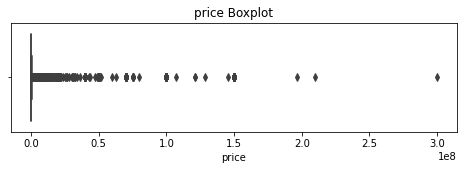

In [784]:
viz_boxplot(data= df, target_column= 'price')

Q1: 35000.0
Q1: 281000.0
IQR (Q1-Q2): 246000.0
Lower limit: -334000.0
Upper limit: 650000.0
Total Outliers: 10178
Total rows before dropping outliers	: 56999
Total rows before after outliers	: 46821


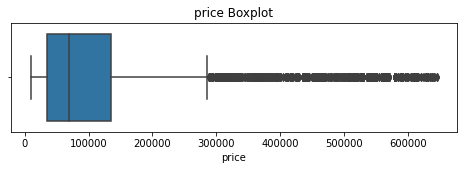

In [785]:
outlier_search(data = df, target_column = 'price')
viz_boxplot(data= df, target_column= 'price')

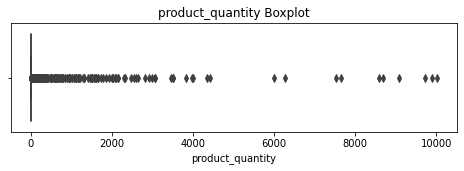

In [786]:
viz_boxplot(data= df, target_column= 'product_quantity')

Q1: 11
Q1: 15
IQR (Q1-Q2): 4
Lower limit: 5.0
Upper limit: 21.0
Total Outliers: 4206
Total rows before dropping outliers	: 46821
Total rows before after outliers	: 42615


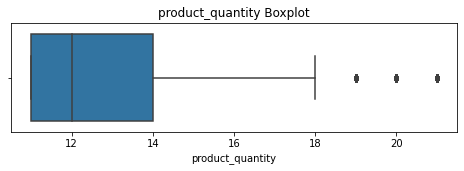

In [787]:
outlier_search(data = df, target_column = 'product_quantity')
viz_boxplot(data= df, target_column= 'product_quantity')

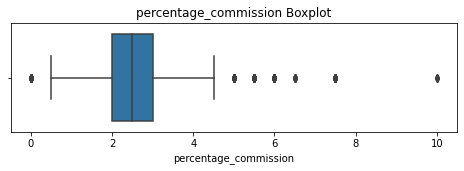

In [788]:
viz_boxplot(data= df, target_column= 'percentage_commission')

Q1: 2.0
Q1: 3.0
IQR (Q1-Q2): 1.0
Lower limit: 0.5
Upper limit: 4.5
Total Outliers: 10775
Total rows before dropping outliers	: 42615
Total rows before after outliers	: 31840


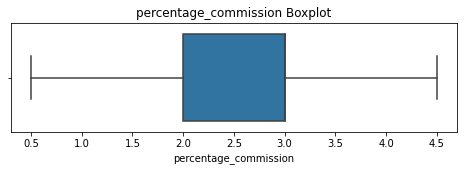

In [789]:
outlier_search(data = df, target_column = 'percentage_commission')
viz_boxplot(data= df, target_column= 'percentage_commission')

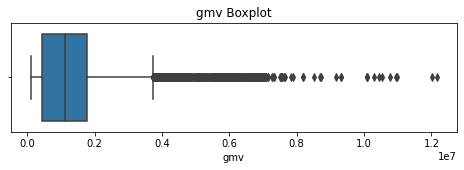

In [828]:
viz_boxplot(data= df, target_column= 'gmv')

Q1: 450000.0
Q1: 1760000.0
IQR (Q1-Q2): 1310000.0
Lower limit: -1515000.0
Upper limit: 3725000.0
Total Outliers: 1876
Total rows before dropping outliers	: 31840
Total rows before after outliers	: 29964


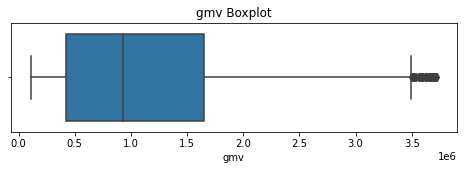

In [829]:
outlier_search(data = df, target_column = 'gmv')
viz_boxplot(data= df, target_column= 'gmv')

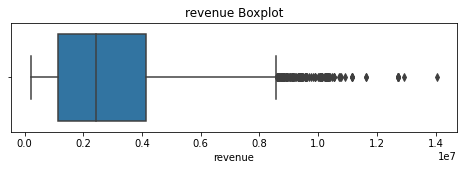

In [830]:
viz_boxplot(data= df, target_column= 'revenue')

Q1: 1155000.0
Q1: 4125000.0
IQR (Q1-Q2): 2970000.0
Lower limit: -3300000.0
Upper limit: 8580000.0
Total Outliers: 356
Total rows before dropping outliers	: 29964
Total rows before after outliers	: 29608


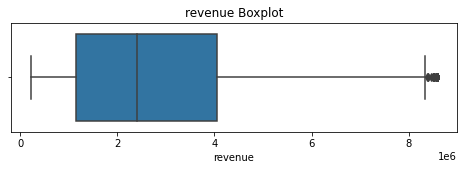

In [831]:
outlier_search(data = df, target_column = 'revenue')
viz_boxplot(data= df, target_column= 'revenue')

# D.	Data Transformation

### Duplicate df table

In [832]:
df_cleaned = df.copy()

### Total list of duplicate data

In [833]:
df_cleaned.duplicated()[df_cleaned.duplicated() == True]

4072     True
4073     True
4074     True
4075     True
4076     True
4077     True
4078     True
4079     True
21459    True
21460    True
21461    True
21462    True
21463    True
21464    True
21465    True
21466    True
dtype: bool

### Dropping duplicate data

In [834]:
df_cleaned.drop_duplicates(inplace = True)

In [835]:
df_cleaned.duplicated()[df_cleaned.duplicated() == True]

Series([], dtype: bool)

### Fix messy strings in province name

In [836]:
df_ = df_cleaned[['buyer_province_name','order_id']]
df_ = df_.groupby('buyer_province_name')['order_id'].count()
print(df_)

buyer_province_name
Bali                        1496
Bangka Belitung                1
Banten                      4828
Bengkulu                       1
DI Yogyakarta                173
DKI Jakarta                 5254
Dki Jakarta                    4
Jambi                          3
Jawa Barat                  4001
Jawa Tengah                 7547
Jawa Timur                  1986
Kalimantan Selatan             2
Kalimantan Timur               2
Kepulauan Riau               786
Lampung                        4
Nanggroe Aceh Darussalam       1
Nusa Tenggara Barat            1
Riau                        2603
Sulawesi Selatan               5
Sulawesi Tengah                1
Sumatera Barat               385
Sumatera Selatan              65
Sumatera Utara               443
Name: order_id, dtype: int64


In [837]:
df_cleaned.buyer_province_name.replace({
    'Dki Jakarta': 'DKI Jakarta',
    'Di Yogyakarta': 'DI Yogyakarta',
    '^.*nad.*$': 'Nanggroe Aceh Darussalam',
    '^.*ntb.*$': 'Nusa Tenggara Barat'
    }, inplace=True, regex=True)

In [838]:
df_ = df_cleaned[['buyer_province_name','order_id']]
df_ = df_.groupby('buyer_province_name')['order_id'].count()
print(df_)

buyer_province_name
Bali                        1496
Bangka Belitung                1
Banten                      4828
Bengkulu                       1
DI Yogyakarta                173
DKI Jakarta                 5258
Jambi                          3
Jawa Barat                  4001
Jawa Tengah                 7547
Jawa Timur                  1986
Kalimantan Selatan             2
Kalimantan Timur               2
Kepulauan Riau               786
Lampung                        4
Nanggroe Aceh Darussalam       1
Nusa Tenggara Barat            1
Riau                        2603
Sulawesi Selatan               5
Sulawesi Tengah                1
Sumatera Barat               385
Sumatera Selatan              65
Sumatera Utara               443
Name: order_id, dtype: int64


### Fix messy strings in order source

In [839]:
df_cleaned['order_source'].value_counts()

Android       22269
website        4638
CMS            1246
Web Ralali      973
ios             466
Name: order_source, dtype: int64

In [840]:
mobile = '|'.join(['Android', 'ios'])
website = '|'.join(['website', 'Web neverforget', 'CMS'])

df_cleaned['order_source'].replace({
    mobile:'Mobile',
    website:'Website'
    }, inplace=True, regex=True)

In [841]:
df_cleaned['order_source'].value_counts()

Mobile     22735
Website     6857
Name: order_source, dtype: int64

### Export table to CSV

In [842]:
df_cleaned.to_csv('df_pbl-76.csv', encoding='utf-8', index=False)

# E.	Exploratory Data Analysis

### Find the average time

In [843]:
df_cleaned['avg'] = df_cleaned['received_datetime'] - df_cleaned['delivered_datetime']
df_cleaned['avg']

1245     0 days 03:40:35
1246     0 days 03:42:37
1247     0 days 03:48:59
1249     0 days 00:01:21
1250     0 days 00:01:21
              ...       
56993    0 days 14:57:04
56994    0 days 00:00:08
56995   13 days 23:17:51
56996   13 days 23:15:47
56997    0 days 00:00:21
Name: avg, Length: 29592, dtype: timedelta64[ns]

In [844]:
avg_deliv = df_cleaned['avg'].mean()
print('The average time from delivery of goods to receipt by the buyer:', avg_deliv)

The average time from delivery of goods to receipt by the buyer: 1 days 23:13:12.950740360


### Find total orders

In [845]:
total_ord = df_cleaned['order_id'].count()
print('Total orders:', total_ord)

Total orders: 29592


### Orders Made Trendline

/usr/local/lib/python3.8/dist-packages/pandas/io/sql.py:717: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


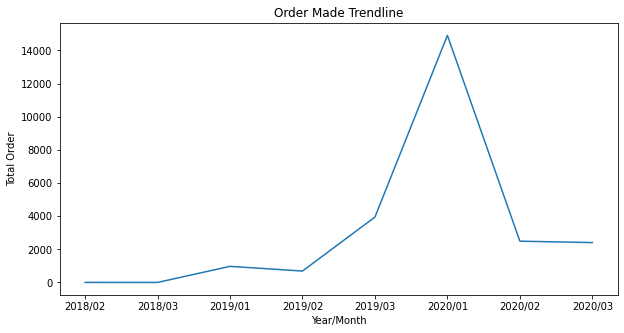

In [846]:
date_df = sql_run(
    """
    SELECT
        strftime('%Y/%m', order_datetime) as YearMonth,
        count(distinct order_id) total_order
    from df_cleaned
    GROUP BY 1
    """
)
plt.figure(figsize=(10,5))
plt.plot(date_df.YearMonth, date_df.total_order)
plt.xlabel('Year/Month', size= 10)
plt.ylabel('Total Order')
plt.title('Order Made Trendline')
plt.show()

### Total Unique Item Sold Trendline

/usr/local/lib/python3.8/dist-packages/pandas/io/sql.py:717: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


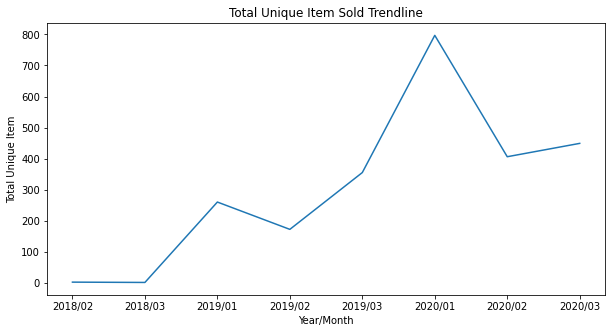

In [847]:
date_df = sql_run(
    """
    SELECT
        strftime('%Y/%m', order_datetime) as YearMonth,
        count(distinct item_id) totaluniqueitem
    from df_cleaned
    GROUP BY 1
    """
)
plt.figure(figsize=(10,5))
plt.plot(date_df.YearMonth, date_df.totaluniqueitem)
plt.xlabel('Year/Month', size= 10)
plt.ylabel('Total Unique Item')
plt.title('Total Unique Item Sold Trendline')
plt.show()

### Find total GMV

In [848]:
total_gmv = df_cleaned['gmv'].sum()
print('Total GMV: Rp. {:,.2f}'.format(total_gmv))

Total GMV: Rp. 32,931,959,883.00


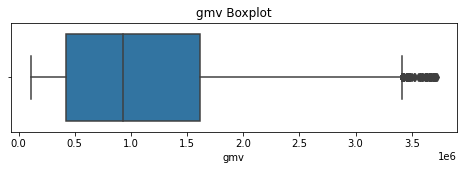

In [849]:
viz_boxplot(data= df_cleaned, target_column= 'gmv')

/usr/local/lib/python3.8/dist-packages/pandas/io/sql.py:717: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


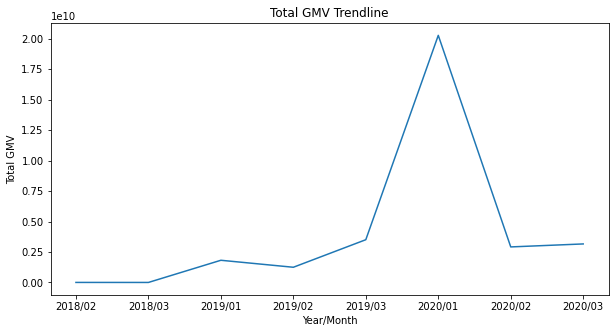

In [850]:
date_df = sql_run(
    """
    SELECT
        strftime('%Y/%m', order_datetime) as YearMonth,
        SUM(gmv) total_gmv
    from df_cleaned
    GROUP BY 1
    """
)
plt.figure(figsize=(10,5))
plt.plot(date_df.YearMonth, date_df.total_gmv)
plt.xlabel('Year/Month', size= 10)
plt.ylabel('Total GMV')
plt.title('Total GMV Trendline')
plt.show()

### Find total Revenue

In [851]:
total_rev = df_cleaned['revenue'].sum()
print('Total Revenue: Rp. {:,.2f}'.format(total_rev))

Total Revenue: Rp. 83,598,227,273.00


In [852]:
highest_rev = df_cleaned['revenue'].max()
lowest_rev = df_cleaned['revenue'].min()
avg_rev = df_cleaned['revenue'].mean()
print(f'Highest revenue\t: {highest_rev}\nLowest revenue\t: {lowest_rev}\nAverage revenue\t: {avg_rev}')

Highest revenue	: 8580000.0
Lowest revenue	: 220000.0
Average revenue	: 2825027.955967829


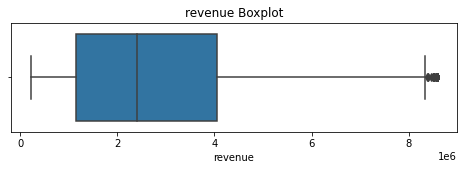

In [853]:
viz_boxplot(data= df_cleaned, target_column= 'revenue')

/usr/local/lib/python3.8/dist-packages/pandas/io/sql.py:717: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


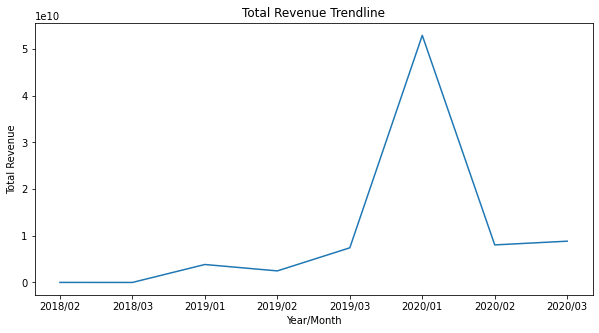

In [854]:
date_df = sql_run(
    """
    SELECT
        strftime('%Y/%m', order_datetime) as YearMonth,
        SUM(revenue) total_revenue
    from df_cleaned
    GROUP BY 1
    """
)
plt.figure(figsize=(10,5))
plt.plot(date_df.YearMonth, date_df.total_revenue)
plt.xlabel('Year/Month', size= 10)
plt.ylabel('Total Revenue')
plt.title('Total Revenue Trendline')
plt.show()

### Payment method with the most total transactions

In [855]:
payment_group['total'] = payment_group['_2018'] + payment_group['_2019'] + payment_group['_2020']
payment_group

,payment_method,_2018,_2019,_2020,total
0,Bank Transfer,8815,10617,30060,49492
1,TOP,459,84,40,583
2,e-Wallet,0,362,6499,6861


In [856]:
top_payment = payment_group[payment_group['total'] == payment_group['total'].max()]
print('Top payment method:', top_payment.loc[0, 'payment_method'])

Top payment method: Bank Transfer


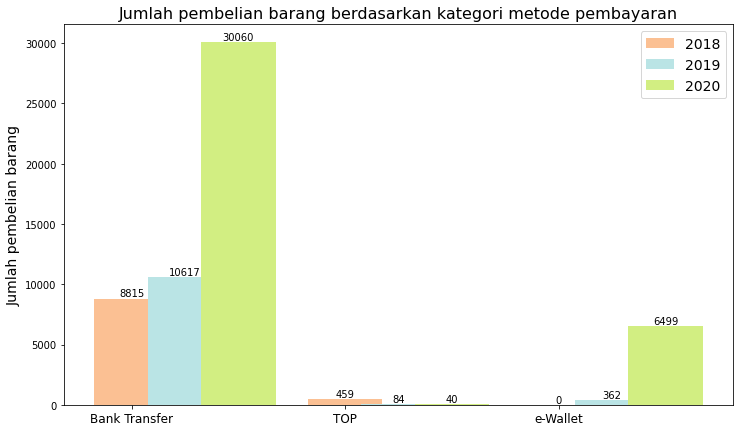

In [857]:
x = np.arange(len(payment_group['payment_method']))
fig, ax = plt.subplots(figsize=(12, 7))
width = 0.35

year2018 = ax.bar(x + 0.00, payment_group['_2018'], width, label='2018', color='#fbc093')
year2019 = ax.bar(x + 0.25, payment_group['_2019'], width, label='2019', color='#bae4e5')
year2020 = ax.bar(x + 0.50, payment_group['_2020'], width, label='2020', color='#d2ee82')

ax.set_title('Jumlah pembelian barang berdasarkan kategori metode pembayaran', size=16)
ax.set_ylabel('Jumlah pembelian barang', size=14)
ax.set_xticks(x)
ax.set_xticklabels(payment_group['payment_method'], size=12)
ax.legend(fontsize=14)

rects = ax.patches
labels = [
    8815, 459, 0,
    10617, 84, 362,
    30060, 40, 6499
    ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

payment_method
BCA Bank Transfer        15098
Ralali Wallet             5390
BCA                       4792
Bank BCA                  1567
BNI                        739
BRI Bank Transfer          472
Mandiri                    429
BRI                        332
Ovo                        252
BNI Bank Transfer          244
Mandiri Bank Transfer      184
Credit Card                 42
Permata                     40
Kredivo                      5
BII                          3
DBS Bank Transfer            2
Payment Nothing              1
Name: order_id, dtype: int64


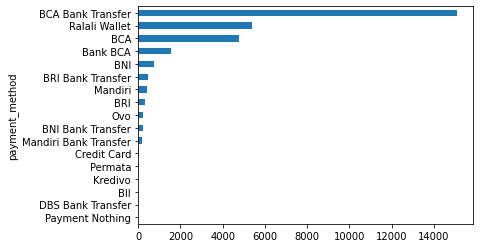

In [858]:
df_ = df_cleaned[['payment_method','order_id']]
df_ = df_.groupby('payment_method')['order_id'].count()
df_.sort_values(ascending=True).plot.barh()
print(df_.sort_values(ascending=False))

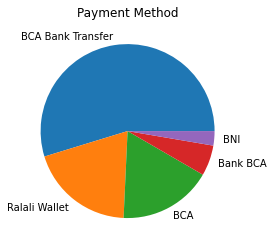

In [859]:
df_cleaned.payment_method.value_counts().sort_values(ascending=False).head().plot.pie()

plt.title('Payment Method')
plt.ylabel('')
plt.show()

### Categories with the highest total revenue

,revenue
cat_name,
Agriculture & Food,61083078936.0
Computer & Communication,16717467290.5
Electronics,1542740600.0
Automotive & Transportation,1492823835.0
Furnitures & Decorations,1334236300.0
Office & Store Supplies,612350659.5
Building Materials,404339990.0
"Beauty, Sport & Fashion",171981360.0
Services,171422000.0


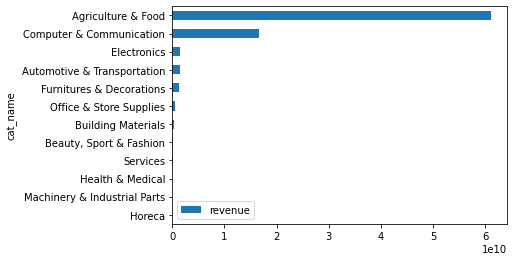

In [860]:
df_cat = df_cleaned[['cat_name', 'revenue']]
cat_group = df_cat.groupby(['cat_name']).sum()
cat_group.sort_values(by=['revenue'], inplace=True, ascending=True)
cat_group.plot.barh()
display(cat_group.sort_values(by=['revenue'], ascending=False))

### Categories with the highest total orders

cat_name
Agriculture & Food              23239
Computer & Communication         4581
Automotive & Transportation       497
Electronics                       347
Office & Store Supplies           327
Furnitures & Decorations          240
Beauty, Sport & Fashion           136
Building Materials                112
Services                           69
Health & Medical                   32
Machinery & Industrial Parts        9
Horeca                              3
Name: order_id, dtype: int64


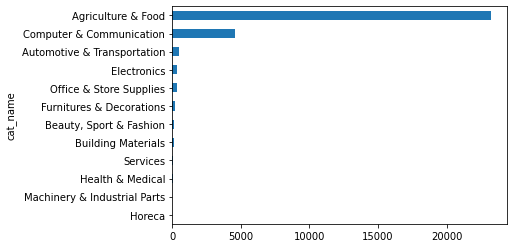

In [861]:
df_ = df_cleaned[['cat_name','order_id']]
df_ = df_.groupby('cat_name')['order_id'].count()
df_.sort_values(ascending=True).plot.barh()
print(df_.sort_values(ascending=False))

### Order source with the highest total orders

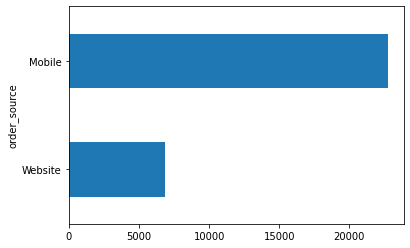

In [862]:
df_ = df_cleaned[['order_source','order_id']]
df_ = df_.groupby('order_source')['order_id'].count()
df_.sort_values(ascending=True).plot.barh()

### Percentage of commissions with the most revenue

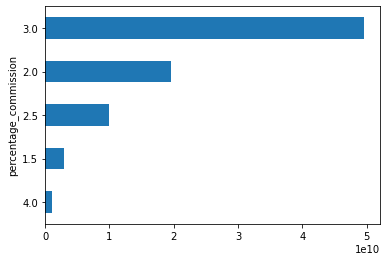

In [863]:
df_ = df_cleaned[['percentage_commission','revenue']]
df_ = df_.groupby('percentage_commission')['revenue'].sum().sort_values(ascending=False).head()
df_.sort_values(ascending=True).plot.barh()

### Most used logistics services

logistic_name
Free Ongkir Lokal        15566
Free Ongkir Nusantara     5810
JNE                       3836
J&T                       2565
TIKI                      1288
Ralali Kargo               253
Wahana                     228
SiCepat                     42
GO-SEND                      4
Name: order_id, dtype: int64

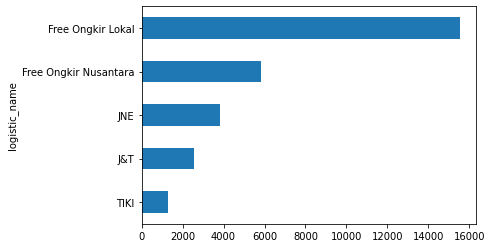

In [864]:
df_ = df_cleaned[['logistic_name','order_id']]
df_ = df_.groupby('logistic_name')['order_id'].count().sort_values(ascending=False)
display(df_)
df_ = df_.head()
df_.sort_values(ascending=True).plot.barh()

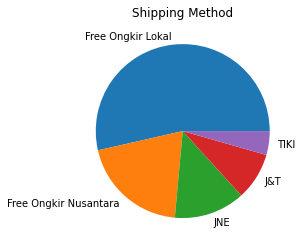

In [865]:
df_cleaned.logistic_name.value_counts().sort_values(ascending=False).head().plot.pie()

plt.title('Shipping Method')
plt.ylabel('')
plt.show()

### Provinces with the highest total orders

buyer_province_name
Jawa Tengah    7547
DKI Jakarta    5262
Banten         4828
Jawa Barat     4009
Riau           2603
Name: order_id, dtype: int64

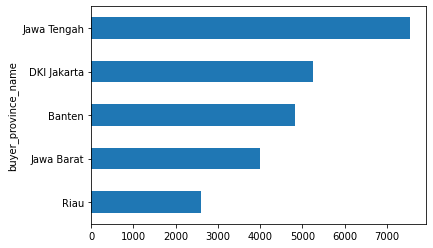

In [866]:
df_ = df[['buyer_province_name','order_id']]
df_ = df_.groupby('buyer_province_name')['order_id'].count().sort_values(ascending=False).head()
df_.sort_values(ascending=True).plot.barh()
display(df_.sort_values(ascending=False))

### Refund status

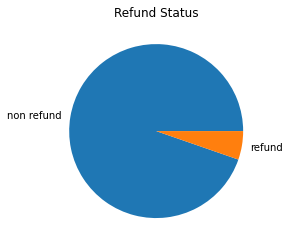

In [867]:
df_cleaned.refund_status.value_counts().sort_values(ascending=False).head().plot.pie()

plt.title('Refund Status')
plt.ylabel('')
plt.show()

### Heatmap

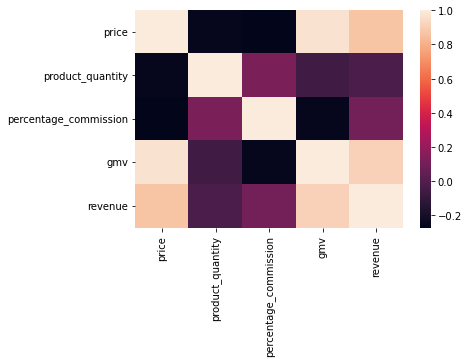

In [868]:
temp_df = df_cleaned[['price', 'product_quantity', 'percentage_commission', 'gmv', 'revenue']]
temp_df
sns.heatmap(temp_df.corr('pearson'))

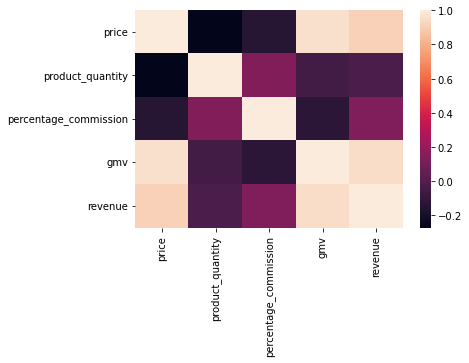

In [869]:
temp_df = df_cleaned[['price', 'product_quantity', 'percentage_commission', 'gmv', 'revenue']]
temp_df
sns.heatmap(temp_df.corr('spearman'))